In [1]:
# !pip install pandas boto3 scikit-learn mlflow s3fs matplotlib seaborn xgboost


In [2]:
import boto3
import pandas as pd
from io import StringIO
import logging
from dotenv import load_dotenv
import os
import sys
sys.path.append('src')
from data_loader import S3DataLoader
from Air_preprocessing import AirbnbPreprocessor
from Ml_flow import MLflowModelTrainer
from Future_engineering import FeatureEngineer
# Load the .env file
load_dotenv()
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
bucket_name = 'staywise-airbnb'
loader = S3DataLoader(bucket_name)


In [4]:
files = loader.list_files()
print(files)


['AB_NYC_2019.csv']


In [5]:
df = loader.load_csv_from_s3('AB_NYC_2019.csv')
print(df.shape)
df.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
print(df.info())
print(df.isnull().sum())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# from preprocessing import AirbnbPreprocessor
# from feature_engineering import FeatureEngineer
# from model_training import MLflowModelTrainer

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [8]:
# print("\n" + "="*80)
print("STEP 1: Loading Data from AWS S3")
# print("="*80)

# Initialize S3 data loader
BUCKET_NAME = 'staywise-airbnb'
FILE_KEY = 'AB_NYC_2019.csv'

loader = S3DataLoader(bucket_name=BUCKET_NAME)

# Load dataset
try:
    df_raw = loader.load_csv_from_s3(FILE_KEY)
    print(f" Successfully loaded dataset: {df_raw.shape}")
except Exception as e:
    print(f" Error loading data: {e}")
    print("Note: Make sure your AWS credentials are configured and S3 bucket exists")
    # For demonstration, create sample data
    print("\nCreating sample dataset for demonstration...")
    df_raw = pd.DataFrame({
        'price': np.random.uniform(50, 300, 1000),
        'bedrooms': np.random.randint(1, 5, 1000),
        'bathrooms': np.random.randint(1, 3, 1000),
        'accommodates': np.random.randint(2, 8, 1000),
        'neighbourhood': np.random.choice(['Downtown', 'Suburbs', 'Midtown'], 1000),
        'room_type': np.random.choice(['Entire home', 'Private room', 'Shared room'], 1000),
        'number_of_reviews': np.random.randint(0, 100, 1000),
        'reviews_per_month': np.random.uniform(0, 5, 1000),
        'availability_365': np.random.randint(0, 365, 1000),
        'name': ['Listing ' + str(i) for i in range(1000)],
        'amenities': ['wifi,kitchen,parking' for _ in range(1000)],
        'latitude': np.random.uniform(40.5, 41.5, 1000),
        'longitude': np.random.uniform(-74.5, -73.5, 1000),
        'host_is_superhost': np.random.choice(['t', 'f'], 1000),
        'calculated_host_listings_count': np.random.randint(1, 10, 1000)
    })
    print(f" Sample dataset created: {df_raw.shape}")


STEP 1: Loading Data from AWS S3
 Successfully loaded dataset: (48895, 16)



STEP 2: Exploratory Data Analysis

Dataset Info:
Shape: (48895, 16)
Memory Usage: 23.45 MB

First 5 rows:
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimu

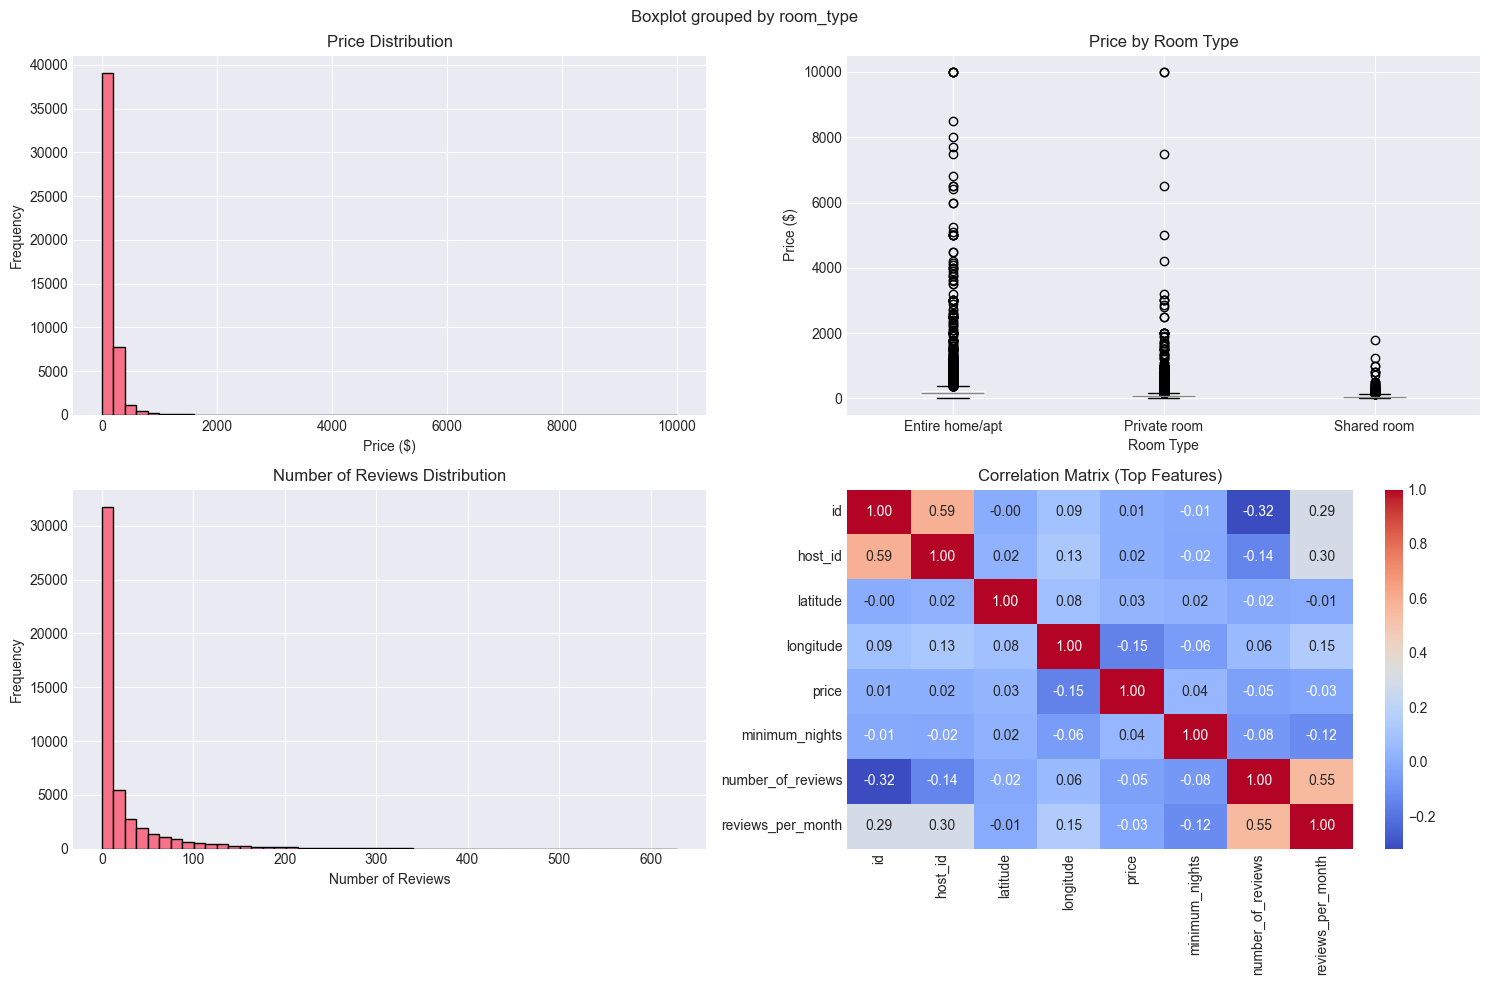

In [9]:

print("\n" + "="*80)
print("STEP 2: Exploratory Data Analysis")
print("="*80)

# Dataset overview
print("\nDataset Info:")
print(f"Shape: {df_raw.shape}")
print(f"Memory Usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print("\nFirst 5 rows:")
print(df_raw.head())

# Data types
print("\nData Types:")
print(df_raw.dtypes.value_counts())

# Missing values
print("\nMissing Values:")
missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

# Price distribution
print("\nPrice Statistics:")
print(df_raw['price'].describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price distribution
axes[0, 0].hist(df_raw['price'], bins=50, edgecolor='black')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')

# Price by room type (if exists)
if 'room_type' in df_raw.columns:
    df_raw.boxplot(column='price', by='room_type', ax=axes[0, 1])
    axes[0, 1].set_title('Price by Room Type')
    axes[0, 1].set_xlabel('Room Type')
    axes[0, 1].set_ylabel('Price ($)')

# Number of reviews distribution
if 'number_of_reviews' in df_raw.columns:
    axes[1, 0].hist(df_raw['number_of_reviews'], bins=50, edgecolor='black')
    axes[1, 0].set_title('Number of Reviews Distribution')
    axes[1, 0].set_xlabel('Number of Reviews')
    axes[1, 0].set_ylabel('Frequency')

# Correlation heatmap (numeric columns)
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns[:8]
corr = df_raw[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlation Matrix (Top Features)')

plt.tight_layout()
plt.savefig('./plot/eda_visualizations.png', dpi=300, bbox_inches='tight')
print("\n EDA visualizations saved to ../eda_visualizations.png")


In [10]:

print("\n" + "="*80)
print("STEP 3: Data Preprocessing")
print("="*80)

# Initialize preprocessor
preprocessor = AirbnbPreprocessor()

# Create a copy for processing
df_processed = df_raw.copy()

# Handle missing values
print("\n--- Handling Missing Values ---")
df_processed = preprocessor.handle_missing_values(df_processed)

# Remove outliers from price
print("\n--- Removing Outliers ---")
df_processed = preprocessor.remove_outliers_iqr(df_processed, ['price'])

# Display results
print(f"\nDataset shape after preprocessing: {df_processed.shape}")
print(f"Rows removed: {len(df_raw) - len(df_processed)}")
print(f"Percentage retained: {len(df_processed)/len(df_raw)*100:.2f}%")



STEP 3: Data Preprocessing

--- Handling Missing Values ---

--- Removing Outliers ---

Dataset shape after preprocessing: (45923, 16)
Rows removed: 2972
Percentage retained: 93.92%


In [11]:

print("\n" + "="*80)
print("STEP 4: Feature Engineering")
print("="*80)

# Initialize feature engineer
engineer = FeatureEngineer()

# Apply all feature engineering
df_features = engineer.create_all_features(df_processed)

print(f"\nFeatures before engineering: {df_processed.shape[1]}")
print(f"Features after engineering: {df_features.shape[1]}")
print(f"New features created: {df_features.shape[1] - df_processed.shape[1]}")

# Display new features
new_cols = [col for col in df_features.columns if col not in df_processed.columns]
print(f"\nNew feature columns: {new_cols[:10]}...")


STEP 4: Feature Engineering

Features before engineering: 16
Features after engineering: 25
New features created: 9

New feature columns: ['name_length', 'name_word_count', 'total_availability', 'availability_ratio', 'review_engagement', 'is_active', 'distance_from_center', 'neighbourhood_density', 'is_professional_host']...


In [12]:
print("\n" + "="*80)
print("STEP 5: Preparing Data for Modeling")
print("="*80)

# Select numeric features only for modeling
X = df_features.select_dtypes(include=[np.number])

# Remove target from features if present
target_col = 'price'
if target_col in X.columns:
    y = X[target_col]
    X = X.drop(columns=[target_col])
else:
    raise ValueError(f"Target column '{target_col}' not found!")

# Remove any remaining NaN values
X = X.fillna(0)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()[:10]}...")

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



STEP 5: Preparing Data for Modeling

Feature matrix shape: (45923, 18)
Target vector shape: (45923,)

Features used: ['id', 'host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'name_length']...

Train set: (36738, 18)
Test set: (9185, 18)


In [13]:

print("\n" + "="*80)
print("STEP 6: Training Models with MLflow")
print("="*80)

# Initialize MLflow trainer
trainer = MLflowModelTrainer(experiment_name='airbnb-price-prediction')

# Train all models
print("\nTraining multiple models...")
print("-" * 80)

results = {}

# Linear Regression
print("\n1. Training Linear Regression...")
model_lr, metrics_lr = trainer.train_linear_regression(X_train, X_test, y_train, y_test)
results['Linear_Regression'] = metrics_lr

# Ridge Regression
print("\n2. Training Ridge Regression...")
model_ridge, metrics_ridge = trainer.train_ridge_regression(X_train, X_test, y_train, y_test, alpha=1.0)
results['Ridge'] = metrics_ridge

# Random Forest
print("\n3. Training Random Forest...")
model_rf, metrics_rf = trainer.train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100)
results['Random_Forest'] = metrics_rf

# Gradient Boosting
print("\n4. Training Gradient Boosting...")
model_gb, metrics_gb = trainer.train_gradient_boosting(X_train, X_test, y_train, y_test, n_estimators=100)
results['Gradient_Boosting'] = metrics_gb

# XGBoost
print("\n5. Training XGBoost...")
model_xgb, metrics_xgb = trainer.train_xgboost(X_train, X_test, y_train, y_test, n_estimators=100)
results['XGBoost'] = metrics_xgb

2025/11/22 21:17:43 INFO mlflow.tracking.fluent: Experiment with name 'airbnb-price-prediction' does not exist. Creating a new experiment.



STEP 6: Training Models with MLflow

Training multiple models...
--------------------------------------------------------------------------------

1. Training Linear Regression...


2025/11/22 21:17:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 21:17:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/22 21:17:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



2. Training Ridge Regression...


2025/11/22 21:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



3. Training Random Forest...


2025/11/22 21:18:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 21:18:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



4. Training Gradient Boosting...


2025/11/22 21:18:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 21:19:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



5. Training XGBoost...


2025/11/22 21:19:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/22 21:19:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



STEP 7: Model Comparison and Selection

Model Performance Comparison:
                      rmse      mae  r2_score
Linear_Regression  63.7374  50.5490    0.1279
Ridge              63.7364  50.5521    0.1279
Random_Forest      54.0466  40.6965    0.3729
Gradient_Boosting  55.6378  42.5647    0.3355
XGBoost            54.2024  40.9434    0.3693

BEST MODEL: Random_Forest
RMSE: 54.0466
R² Score: 0.3729

 Model comparison plot saved to ../plots/model_comparison.png


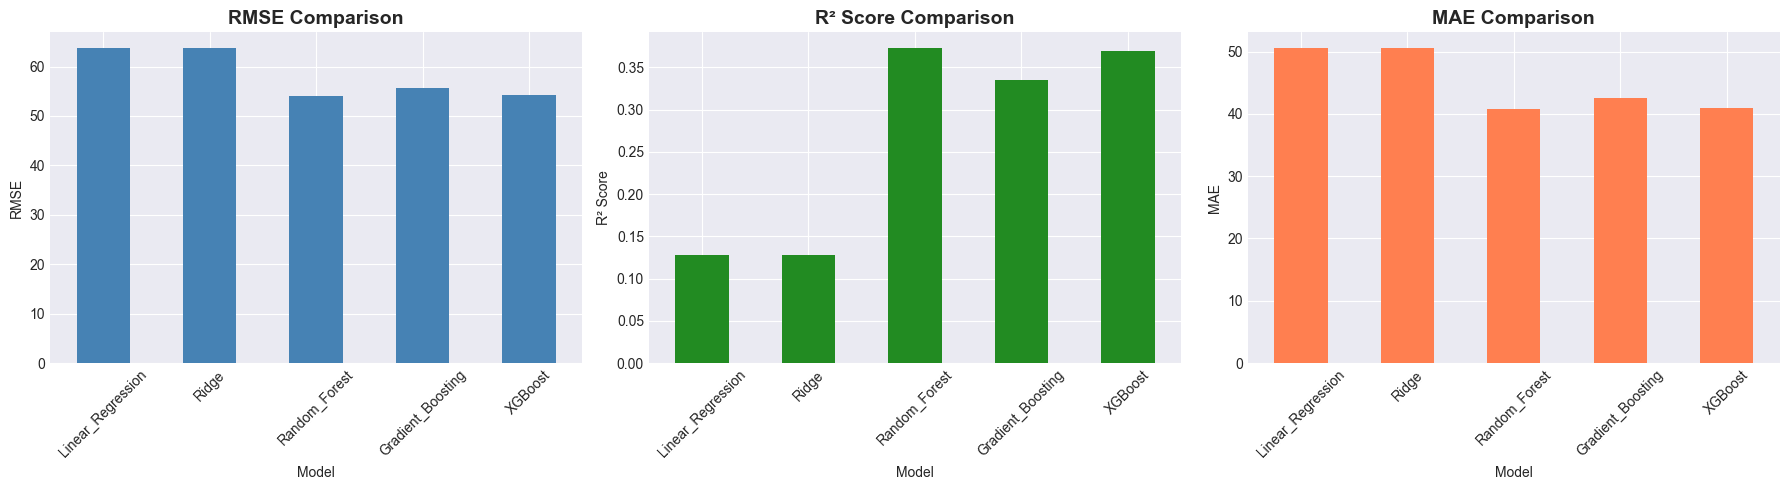

In [14]:

print("\n" + "="*80)
print("STEP 7: Model Comparison and Selection")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Identify best model
best_model_name = comparison_df['rmse'].idxmin()
best_rmse = comparison_df.loc[best_model_name, 'rmse']
best_r2 = comparison_df.loc[best_model_name, 'r2_score']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse:.4f}")
print(f"R² Score: {best_r2:.4f}")
print(f"{'='*80}")

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
comparison_df['rmse'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)

# R² comparison
comparison_df['r2_score'].plot(kind='bar', ax=axes[1], color='forestgreen')
axes[1].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('R² Score')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)

# MAE comparison
comparison_df['mae'].plot(kind='bar', ax=axes[2], color='coral')
axes[2].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAE')
axes[2].set_xlabel('Model')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./plot/model_comparison.png', dpi=300, bbox_inches='tight')
print("\n Model comparison plot saved to ../plots/model_comparison.png")


In [15]:

print("\n" + "="*80)
print("STEP 8: Registering Best Model to MLflow")
print("="*80)

# Register the best model
registered_model = trainer.register_best_model(model_name='airbnb-price-predictor')

if registered_model:
    print(f"\nModel successfully registered!")
    print(f"Model Name: {registered_model.name}")
    print(f"Version: {registered_model.version}")
else:
    print("\nModel registration failed")



STEP 8: Registering Best Model to MLflow


Successfully registered model 'airbnb-price-predictor'.
2025/11/22 21:19:11 WARNING mlflow.tracking._model_registry.fluent: Run with id d832ab6c8cf94c97910f0b0d6d241c4e has no artifacts at artifact path 'model', registering model based on models:/m-60323f22bd8f442981a24d337b2acecc instead
Created version '1' of model 'airbnb-price-predictor'.


Model successfully registered!
Model Name: airbnb-price-predictor
Version: 1



STEP 9: Feature Importance Analysis

Top 15 Most Important Features:
                           feature  importance
3                        longitude    0.227573
2                         latitude    0.140685
15            distance_from_center    0.090772
1                          host_id    0.086218
0                               id    0.074208
9                      name_length    0.054145
7   calculated_host_listings_count    0.049226
6                reviews_per_month    0.046928
4                   minimum_nights    0.039870
13               review_engagement    0.039410
10                 name_word_count    0.029947
5                number_of_reviews    0.028644
8                 availability_365    0.023806
11              total_availability    0.022880
12              availability_ratio    0.022714

 Feature importance plot saved to ../plots/feature_importance.png


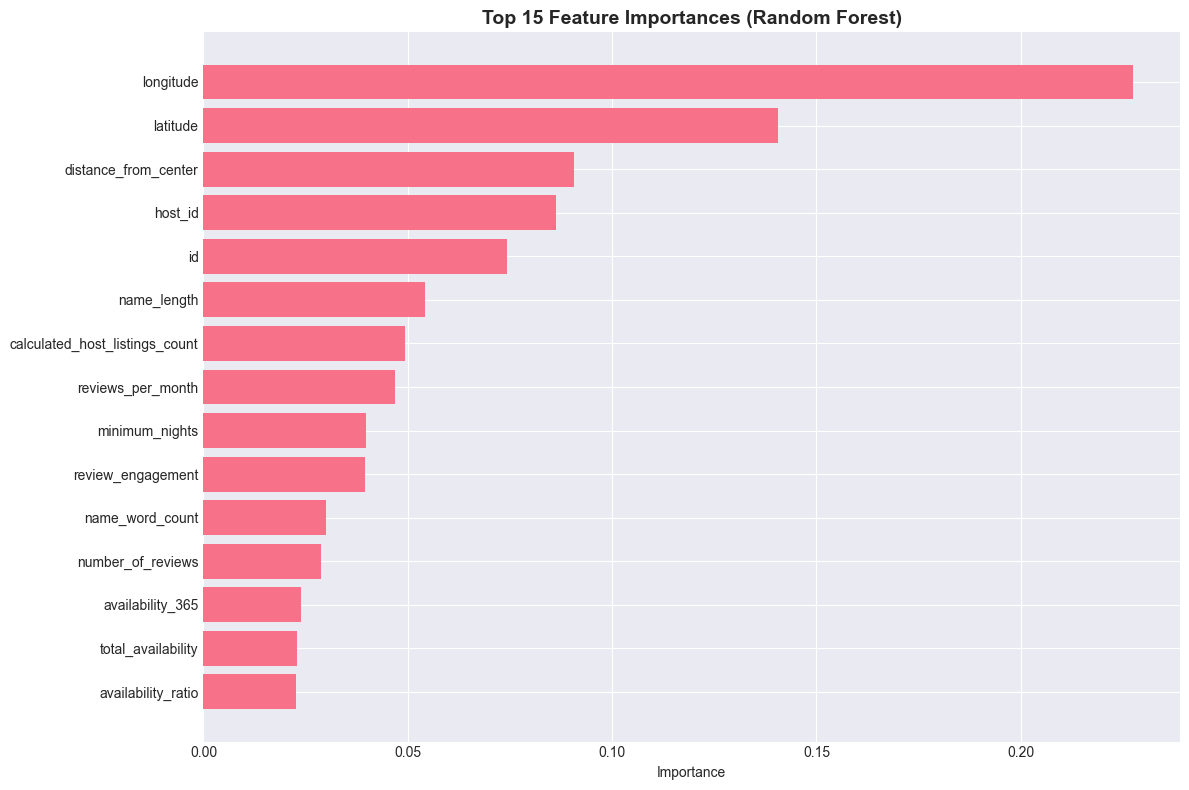

In [16]:

print("\n" + "="*80)
print("STEP 9: Feature Importance Analysis")
print("="*80)

# Get feature importance from Random Forest model
if hasattr(model_rf, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('./plot/feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n Feature importance plot saved to ../plots/feature_importance.png")
